In [1]:
import pandas as pd

### Model Training

In [2]:
df = pd.read_csv('./data/affair.csv')
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


In [3]:
## Add "affair" column: 1 -> represents having affairs, 0 -> represents not having affairs
df['affair'] = (df.affairs > 0).astype(int)  # converting into binary features
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1


In [5]:
## Prepare Data for Logistic Regression
import numpy as np
from patsy import dmatrices

y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + religious + educ + C(occupation) + C(occupation_husb)', df, return_type="dataframe")

X = X.rename(columns = {
    'C(occupation)[T.2.0]':'occ_2',
    'C(occupation)[T.3.0]':'occ_3',
    'C(occupation)[T.4.0]':'occ_4',
    'C(occupation)[T.5.0]':'occ_5',
    'C(occupation)[T.6.0]':'occ_6',
    'C(occupation_husb)[T.2.0]':'occ_husb_2',
    'C(occupation_husb)[T.3.0]':'occ_husb_3',
    'C(occupation_husb)[T.4.0]':'occ_husb_4',
    'C(occupation_husb)[T.5.0]':'occ_husb_5',
    'C(occupation_husb)[T.6.0]':'occ_husb_6'
    }
)

y = np.ravel(y)

In [29]:
X = X.drop(labels=['Intercept'],axis=1)

In [30]:
## segregate numerical and categorical columns
numerical_cols = X.select_dtypes(exclude='object').columns
categorical_cols = X.select_dtypes(include='object').columns

print("Numerical columns:",numerical_cols)
print('Categorical Columns:',categorical_cols)

Numerical columns: Index(['occ_2', 'occ_3', 'occ_4', 'occ_5', 'occ_6', 'occ_husb_2', 'occ_husb_3',
       'occ_husb_4', 'occ_husb_5', 'occ_husb_6', 'rate_marriage', 'age',
       'yrs_married', 'children', 'religious', 'educ'],
      dtype='object')
Categorical Columns: Index([], dtype='object')


In [ ]:
# categorical_cols not available so custom ranking for ordinal variable not required

In [31]:
from sklearn.impute import SimpleImputer ## HAndling Missing Values
from sklearn.preprocessing import StandardScaler # HAndling Feature Scaling
from sklearn.preprocessing import OrdinalEncoder # Ordinal Encoding
## pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [32]:
## Numerical Pipeline
num_pipeline = Pipeline(
    steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
    ]
)

## Categorigal Pipeline
cat_pipeline = Pipeline(
    steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('ordinalencoder',OrdinalEncoder(categories=[])),
    ('scaler',StandardScaler())
    ]
)

## preprocessor
preprocessor = ColumnTransformer([
('num_pipeline',num_pipeline,numerical_cols),
('cat_pipeline',cat_pipeline,categorical_cols)
])

In [33]:
## Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [34]:
# check imbalance in the training data
y_0 = y_train[y_train == 0]
y_1 = y_train[y_train == 1]
print(len(y_0), len(y_1))

3420 1672


In [ ]:
### dataset is imbalanced because class 0 is almost double of class 1

In [35]:
# up sampling to balance the dataset
# ! pip install imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train2, y_train2 = ros.fit_resample(X_train, y_train)

In [36]:
# check data counts now
y_0 = y_train2[y_train2 == 0]
y_1 = y_train2[y_train2 == 1]
print(len(y_0), len(y_1))

3420 3420


In [37]:
# apply preprocessor
X_train2 = pd.DataFrame(preprocessor.fit_transform(X_train2), columns=preprocessor.get_feature_names_out())
X_test = pd.DataFrame(preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())

In [38]:
X_train2.head()

,num_pipeline__occ_2,num_pipeline__occ_3,num_pipeline__occ_4,num_pipeline__occ_5,num_pipeline__occ_6,num_pipeline__occ_husb_2,num_pipeline__occ_husb_3,num_pipeline__occ_husb_4,num_pipeline__occ_husb_5,num_pipeline__occ_husb_6,num_pipeline__rate_marriage,num_pipeline__age,num_pipeline__yrs_married,num_pipeline__children,num_pipeline__religious,num_pipeline__educ
0,-0.383251,1.112095,-0.624017,-0.370858,-0.136992,-0.50137,3.251708,-0.679826,-0.627636,-0.298036,-0.994181,-1.093418,-0.964283,-1.030743,-0.441843,0.854073
1,-0.383251,1.112095,-0.624017,-0.370858,-0.136992,-0.50137,-0.307531,-0.679826,-0.627636,3.355304,0.998843,0.373969,0.474016,1.070995,-0.441843,2.706279
2,-0.383251,1.112095,-0.624017,-0.370858,-0.136992,-0.50137,-0.307531,1.470965,-0.627636,-0.298036,0.998843,1.107663,-1.238244,-1.030743,0.708597,-0.998133
3,-0.383251,-0.899203,1.602521,-0.370858,-0.136992,-0.50137,-0.307531,1.470965,-0.627636,-0.298036,0.002331,1.107663,-0.073908,-1.030743,0.708597,-0.072030
4,-0.383251,-0.899203,1.602521,-0.370858,-0.136992,-0.50137,-0.307531,1.470965,-0.627636,-0.298036,0.998843,0.373969,-0.964283,-1.030743,-0.441843,2.706279


In [39]:
X_test.head()

,num_pipeline__occ_2,num_pipeline__occ_3,num_pipeline__occ_4,num_pipeline__occ_5,num_pipeline__occ_6,num_pipeline__occ_husb_2,num_pipeline__occ_husb_3,num_pipeline__occ_husb_4,num_pipeline__occ_husb_5,num_pipeline__occ_husb_6,num_pipeline__rate_marriage,num_pipeline__age,num_pipeline__yrs_married,num_pipeline__children,num_pipeline__religious,num_pipeline__educ
0,-0.383251,1.112095,-0.624017,-0.370858,-0.136992,-0.501370,-0.307531,1.470965,-0.627636,-0.298036,0.002331,-1.093418,-0.964283,-1.030743,0.708597,-0.998133
1,-0.383251,-0.899203,-0.624017,-0.370858,7.299706,-0.501370,-0.307531,-0.679826,-0.627636,3.355304,-0.994181,1.841357,1.843823,1.771575,1.859038,2.706279
2,2.609256,-0.899203,-0.624017,-0.370858,-0.136992,-0.501370,-0.307531,1.470965,-0.627636,-0.298036,-2.987206,-1.093418,-0.964283,-1.030743,-0.441843,-2.387288
3,2.609256,-0.899203,-0.624017,-0.370858,-0.136992,-0.501370,-0.307531,1.470965,-0.627636,-0.298036,0.998843,0.373969,-0.073908,-0.330163,-0.441843,1.317125
4,-0.383251,1.112095,-0.624017,-0.370858,-0.136992,1.994534,-0.307531,-0.679826,-0.627636,-0.298036,-1.990694,-1.093418,-0.964283,-0.330163,0.708597,-0.072030


In [40]:
## Model Training
from sklearn.linear_model import LogisticRegression

# instantiate a logistic regression model and fit with X_train2 and y_train2 data
model = LogisticRegression()
model.fit(X_train2, y_train2)

LogisticRegression()

In [53]:
## examine the coefficients

pd.DataFrame(zip(X_train2.columns, np.transpose(model.coef_)))

,0,1
0,num_pipeline__occ_2,[-0.06095148621135152]
1,num_pipeline__occ_3,[0.15797796513772772]
2,num_pipeline__occ_4,[0.04948963765762189]
3,num_pipeline__occ_5,[0.18108498694054237]
4,num_pipeline__occ_6,[0.08921856039642809]
5,num_pipeline__occ_husb_2,[0.11268524175610484]
6,num_pipeline__occ_husb_3,[0.14606596772528319]
7,num_pipeline__occ_husb_4,[0.09132157621364416]
8,num_pipeline__occ_husb_5,[0.08295475476735246]
9,num_pipeline__occ_husb_6,[0.054364506712430594]


In [41]:
## Evaluate model
from sklearn.metrics import accuracy_score

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train2)

print("train set accuracy score: ", accuracy_score(y_train2, y_pred_train))
print("test set accuracy score :",  accuracy_score(y_test, y_pred_test))

train set accuracy score:  0.6814327485380117
test set accuracy score : 0.6962323390894819


In [ ]:
### the model is a generalized model as we see there is not large deviation between training and test accuracy. 

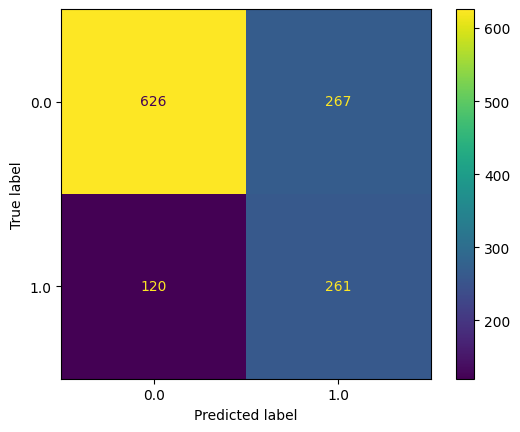

In [51]:
# plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = list(np.unique(y_test))
cm = confusion_matrix(y_test, y_pred_test)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [52]:
# Finding Precision, Recall, F1- Score
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.84      0.70      0.76       893
         1.0       0.49      0.69      0.57       381

    accuracy                           0.70      1274
   macro avg       0.67      0.69      0.67      1274
weighted avg       0.74      0.70      0.71      1274

